In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from SDE_schemes import *
from models import *

# Solving SDEs

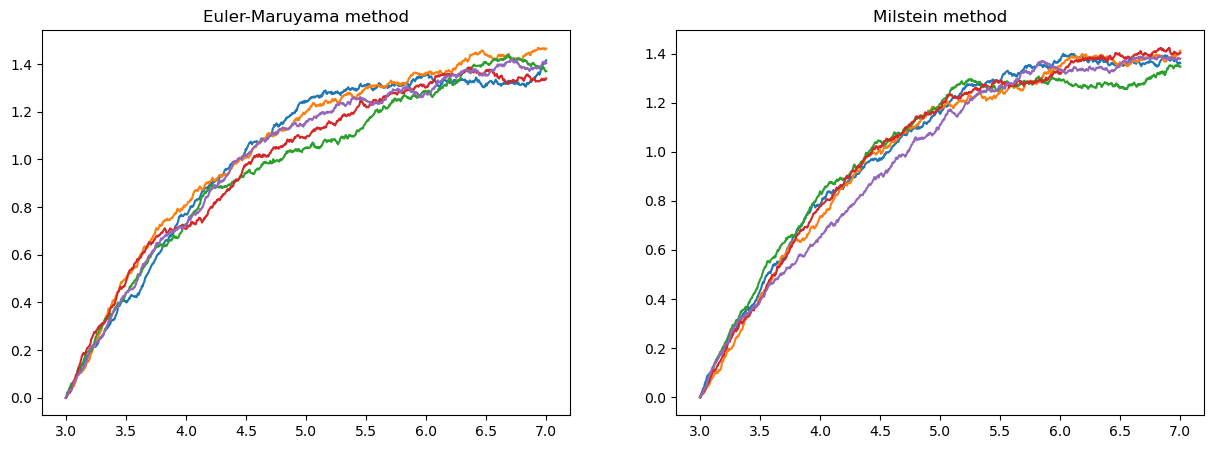

In [2]:
# checking results with wikipedia example - https://pl.wikipedia.org/wiki/Metoda_Eulera-Maruyamy
t0 = 3
tn = 7
N = 1000

def a(x, t):
    return 0.7 * (1.5 - x)

def b(x, t):
    return 0.06

sde = SDE(a, b)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Euler-Maruyama method')
for i in range(5):
    t, x = EulerMaruyamaSolver.performSimulation(sde, 0, t0, tn, N)
    plt.plot(t, x)

#plot 2:
plt.subplot(1, 2, 2)
plt.title('Milstein method')
for i in range(5):
    t, x = MilsteinSolver.performSimulation(sde, 0, t0, tn, N)
    plt.plot(t, x)

plt.show()


# Reading data and preprocessing

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wrcarpenter/Interest-Rate-Models/refs/heads/main/Data/zcbs.csv')
df['Date'] = df['Date'].apply(pd.to_datetime)

df = df.sort_values(by='Date')
df = df.reset_index(drop=True)

df['DaysPassed'] = (df['Date'] - df['Date'][0]).dt.days

df

Date         1         2         3         4         5         6  \
0   2022-10-19  0.997245  0.994006  0.990406  0.986556  0.982548  0.978464   
1   2022-10-20  0.997021  0.993684  0.990071  0.986255  0.982302  0.978266   
2   2022-10-21  0.997046  0.993735  0.990152  0.986373  0.982465  0.978485   
3   2022-10-24  0.997029  0.993663  0.989999  0.986125  0.982120  0.978049   
4   2022-10-25  0.997038  0.993689  0.990047  0.986196  0.982210  0.978154   
..         ...       ...       ...       ...       ...       ...       ...   
342 2024-03-04  0.995419  0.990835  0.986293  0.981831  0.977476  0.973250   
343 2024-03-05  0.995427  0.990853  0.986323  0.981875  0.977538  0.973335   
344 2024-03-06  0.995427  0.990855  0.986328  0.981883  0.977546  0.973341   
345 2024-03-07  0.995419  0.990846  0.986324  0.981889  0.977566  0.973378   
346 2024-03-08  0.995419  0.990844  0.986319  0.981881  0.977558  0.973372   

            7         8         9  ...       352       353       354  \
0    0.974368  0.970310  0.966327  ...  0.298604  0.299035  0.299500   
1    0.974198  0.970136  0.966113  ...  0.291312  0.291720  0.292161   
2    0.974483  0.970497  0.966558  ...  0.281259  0.281669  0.282112   
3    0.973971  0.969933  0.965970  ...  0.274764  0.275096  0.275459   
4    0.974085  0.970049  0.966084  ...  0.285780  0.286166  0.286584   
..        ...       ...       ...  ...       ...       ...       ...   
342  0.969166  0.965231  0.961443  ...  0.277085  0.276992  0.276922   
343  0.969279  0.965378  0.961630  ...  0.284197  0.284155  0.284136   
344  0.969279  0.965368  0.961607  ...  0.287331  0.287195  0.287082   
345  0.969336  0.965446  0.961708  ...  0.285241  0.285091  0.284964   
346  0.969336  0.965456  0.961731  ...  0.284394  0.284212  0.284051   

          355       356       357       358       359       360  DaysPassed  
0    0.299999  0.300533  0.301102  0.301705  0.302344  0.303019           0  
1    0.292635  0.293144  0.293686  0.294262  0.294874  0.295520           1  
2    0.282589  0.283099  0.283642  0.284220  0.284833  0.285480           2  
3    0.275854  0.276280  0.276738  0.277229  0.277753  0.278309           5  
4    0.287036  0.287521  0.288040  0.288593  0.289180  0.289802           6  
..        ...       ...       ...       ...       ...       ...         ...  
342  0.276875  0.276851  0.276850  0.276872  0.276918  0.276988         502  
343  0.284142  0.284173  0.284229  0.284309  0.284415  0.284546         503  
344  0.286991  0.286921  0.286874  0.286849  0.286847  0.286868         504  
345  0.284859  0.284776  0.284716  0.284678  0.284663  0.284672         505  
346  0.283912  0.283794  0.283697  0.283622  0.283568  0.283537         506  

[347 rows x 362 columns]

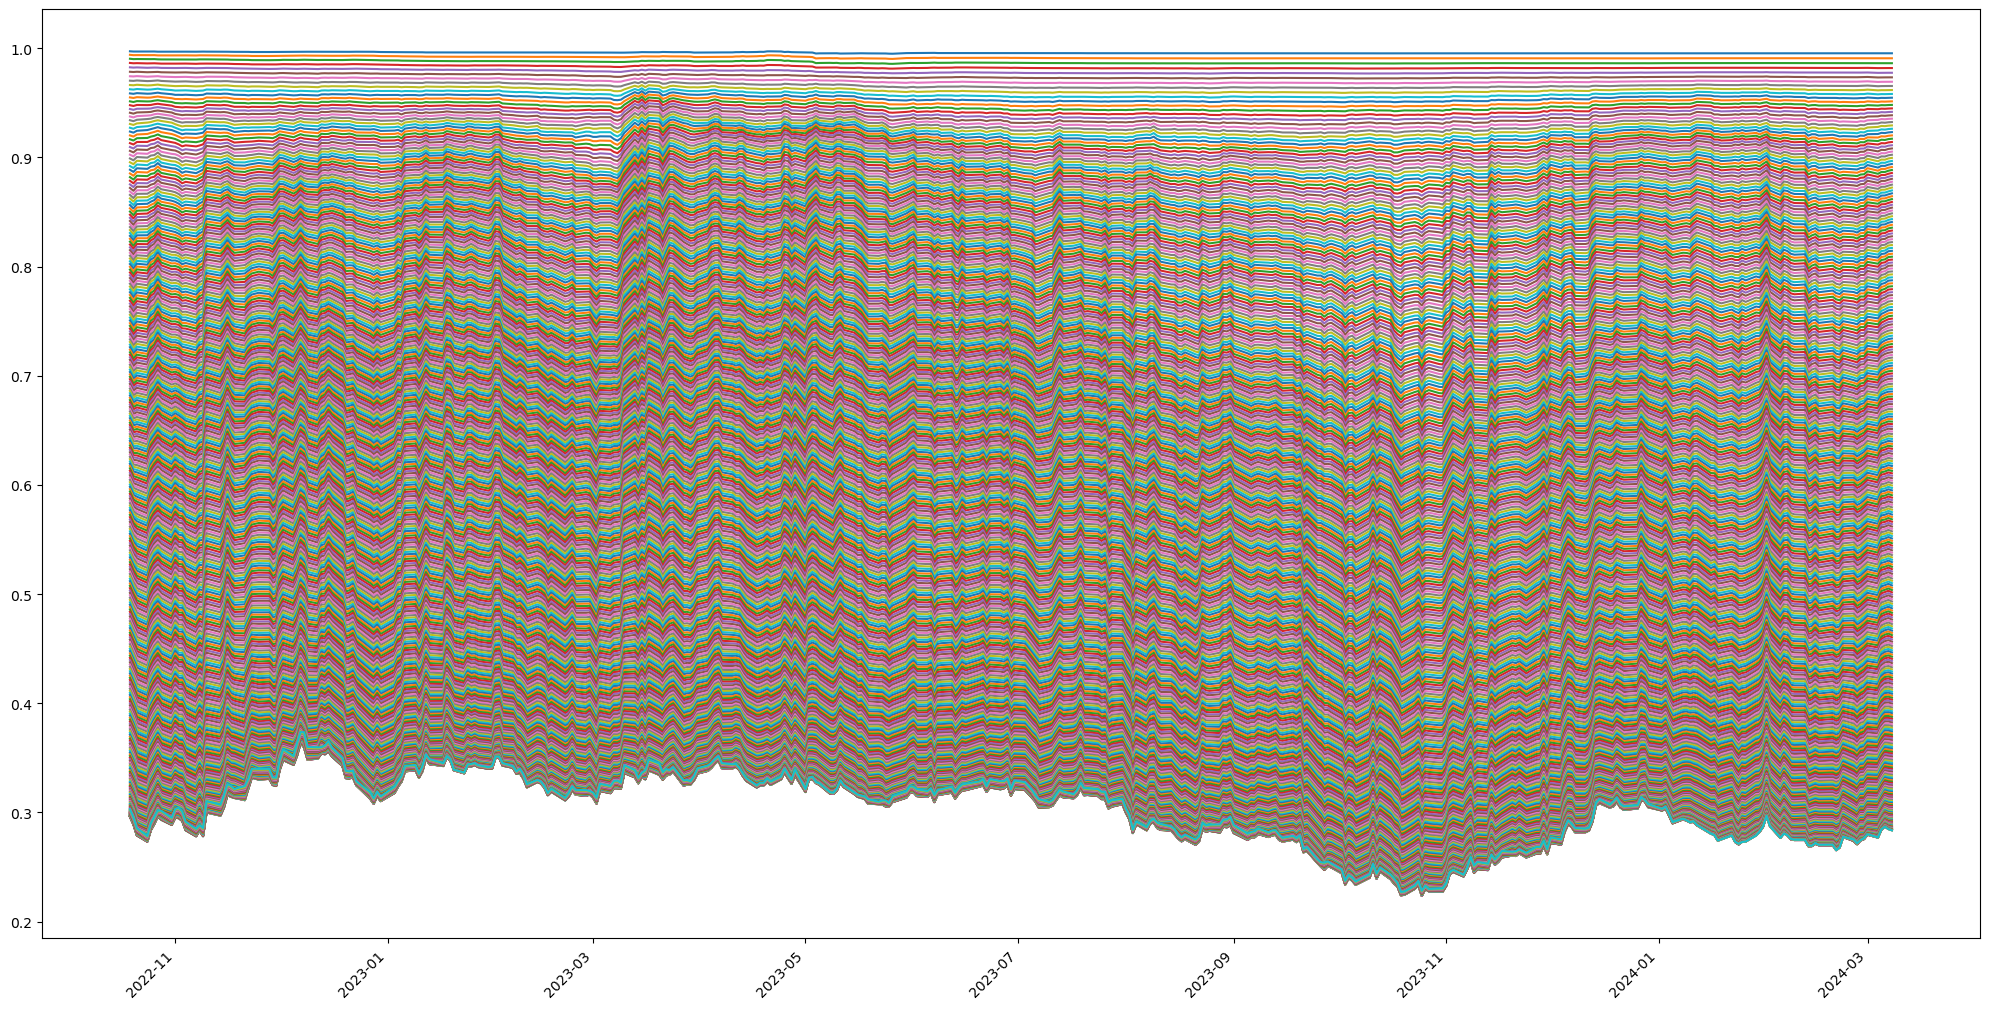

In [4]:
# plotting data
N = 360
dates = df['Date']

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for i in range(1, N+1):
    columnData = df[str(i)]
    plt.plot(dates, columnData, label=f'{i} days')

ylim = plt.gca().get_ylim()
plt.show()

# Calibration

In [5]:
def fit_to_column(model, data):
    model.calibrate(data, 1, 0, len(data)-1)
    print("model parameters:\n", model.alpha, model.sigma, model.theta)

def fit_to_row(model, row):
    firstMaturity = 1
    lastMaturity = 360

    columns = [str(i) for i in range(firstMaturity, lastMaturity+1)]
    data = row[columns]

    model.calibrate(data, 1, firstMaturity, lastMaturity)
    print("model parameters:\n", model.alpha, model.sigma, model.theta)

In [6]:
def plot_results(model, data, t0, tn, N):
    plt.figure(figsize=(20, 10))
    plt.gca().set_ylim(ylim)

    r0 = data.iloc[0]

    # simulating paths
    num_of_simulations = 100
    for i in range(num_of_simulations):
        t, x = EulerMaruyamaSolver.performSimulation(model.getSDE(), r0, t0, tn, N)
        plt.plot(t, x, alpha=0.3)

    # plotting data we are estimating
    plt.plot(np.linspace(t0, tn, N), data, 'k')

    plt.show()


def plot_results_col(model, data):
    N = len(data)
    plot_results(model, data, 0, N-1, N)

def plot_results_row(model, row):
    firstMaturity = 1
    lastMaturity = 360
    N = lastMaturity - firstMaturity + 1

    columns = [str(i) for i in range(firstMaturity, lastMaturity+1)]
    data = row[columns]

    plot_results(model, data, firstMaturity, lastMaturity, N)

## Vasicek model

model parameters:
 0.01256716296022981 0.005769744040449803 0.004087656237601095


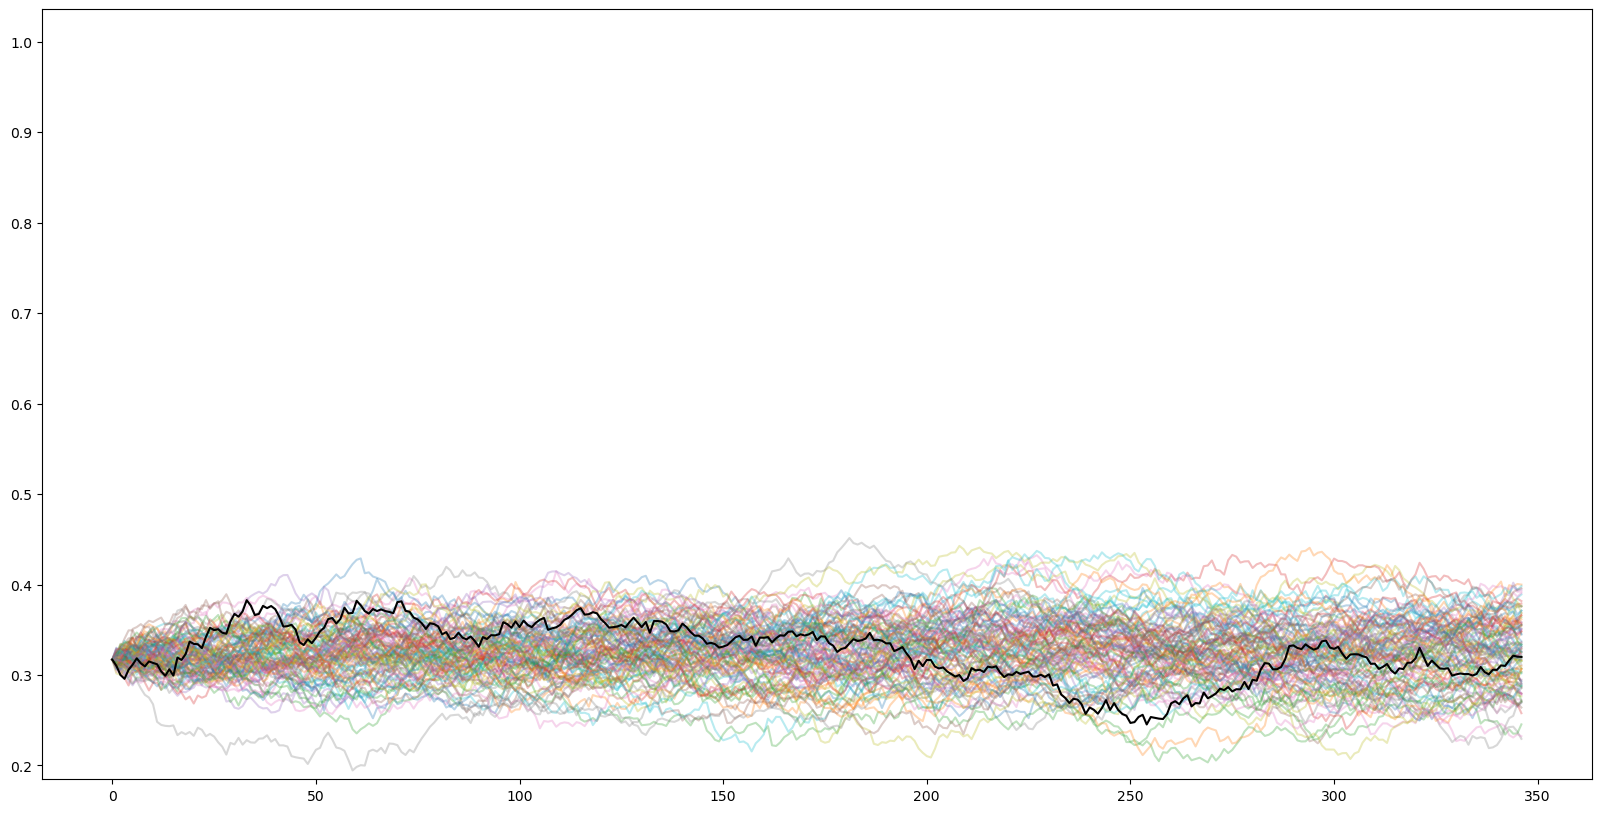

In [7]:
column = df['300']
model = VasicekModel()
fit_to_column(model, column)
plot_results_col(model, column)

model parameters:
 0.003665538954750712 0.00047185154034492225 0.00012932134896884008


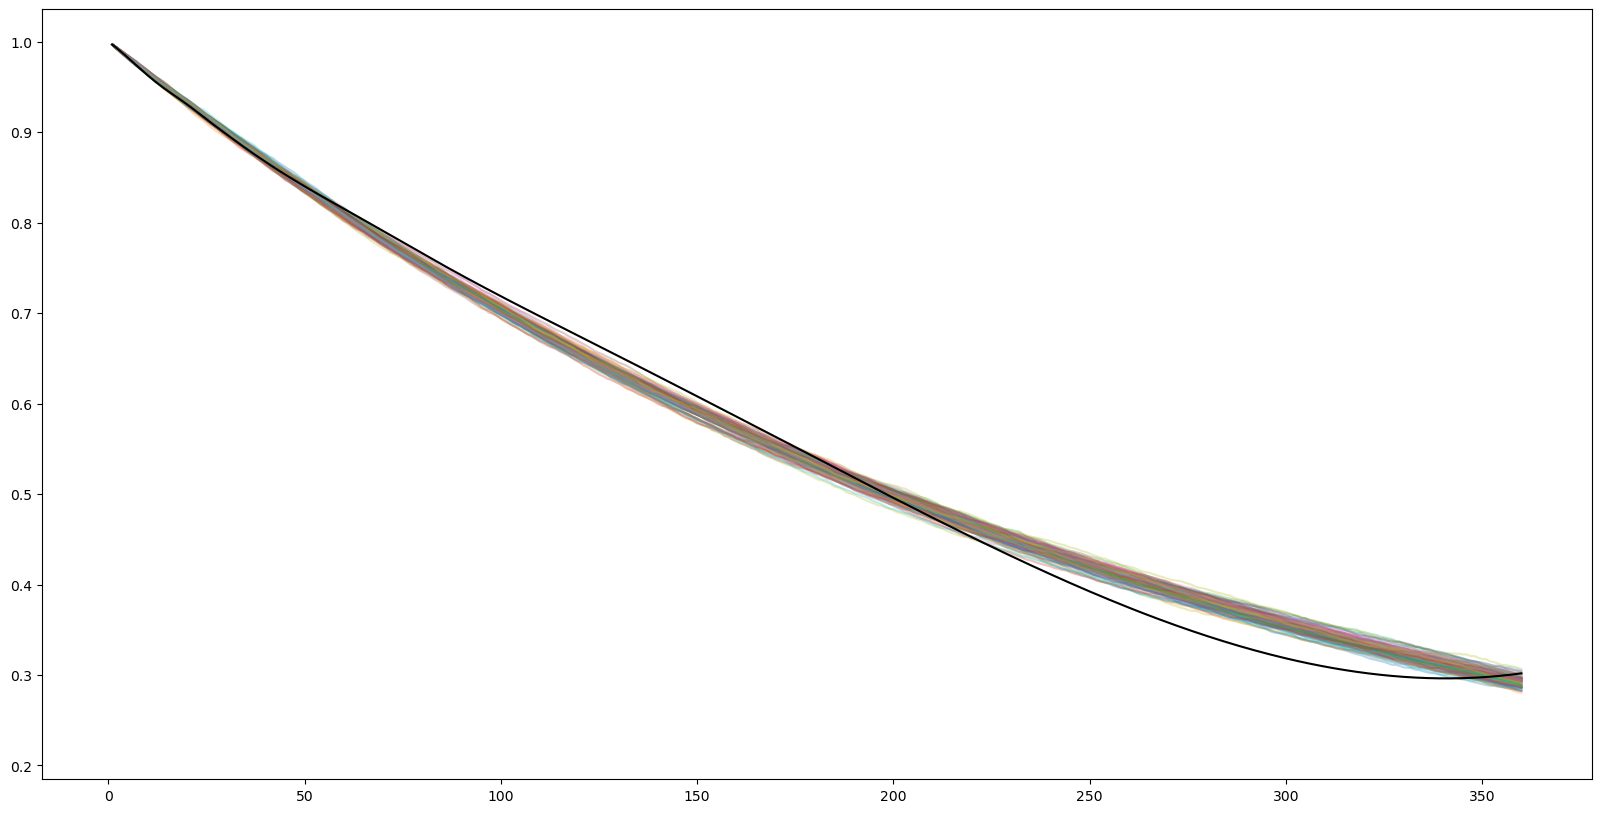

In [8]:
row = df.iloc[6]
model = VasicekModel()
fit_to_row(model, row)
plot_results_row(model, row)

## Cox–Ingersoll–Ross model

model parameters:
 0.015692726772099593 0.010138992153071461 0.005116798062013089


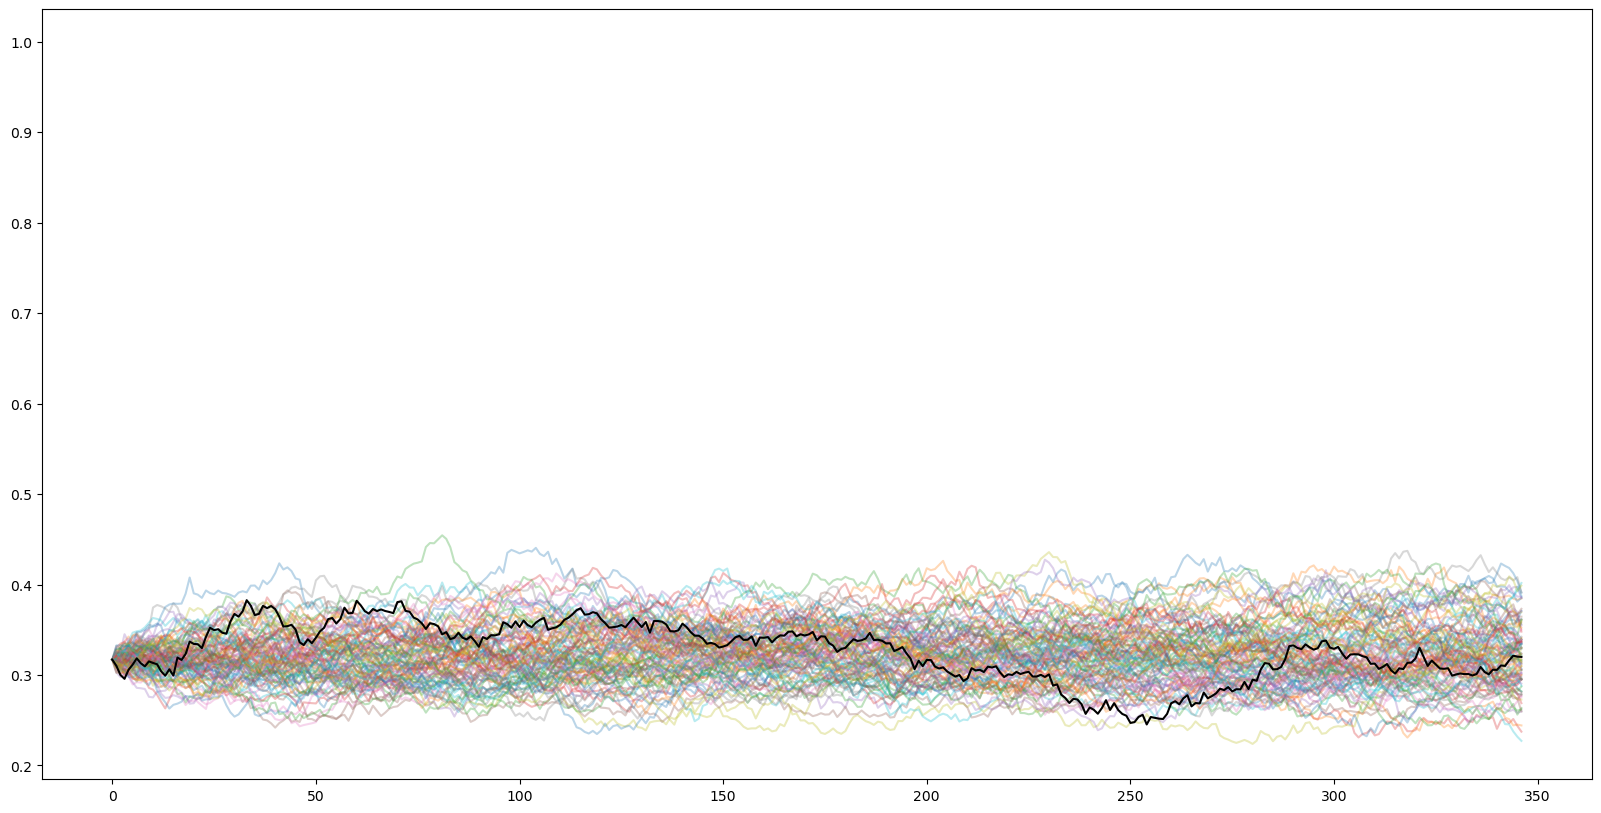

In [9]:
column = df['300']
model = CIRModel()
fit_to_column(model, column)
plot_results_col(model, column)

model parameters:
 0.004098404133883239 0.0007670619174071552 0.0003776056582145122


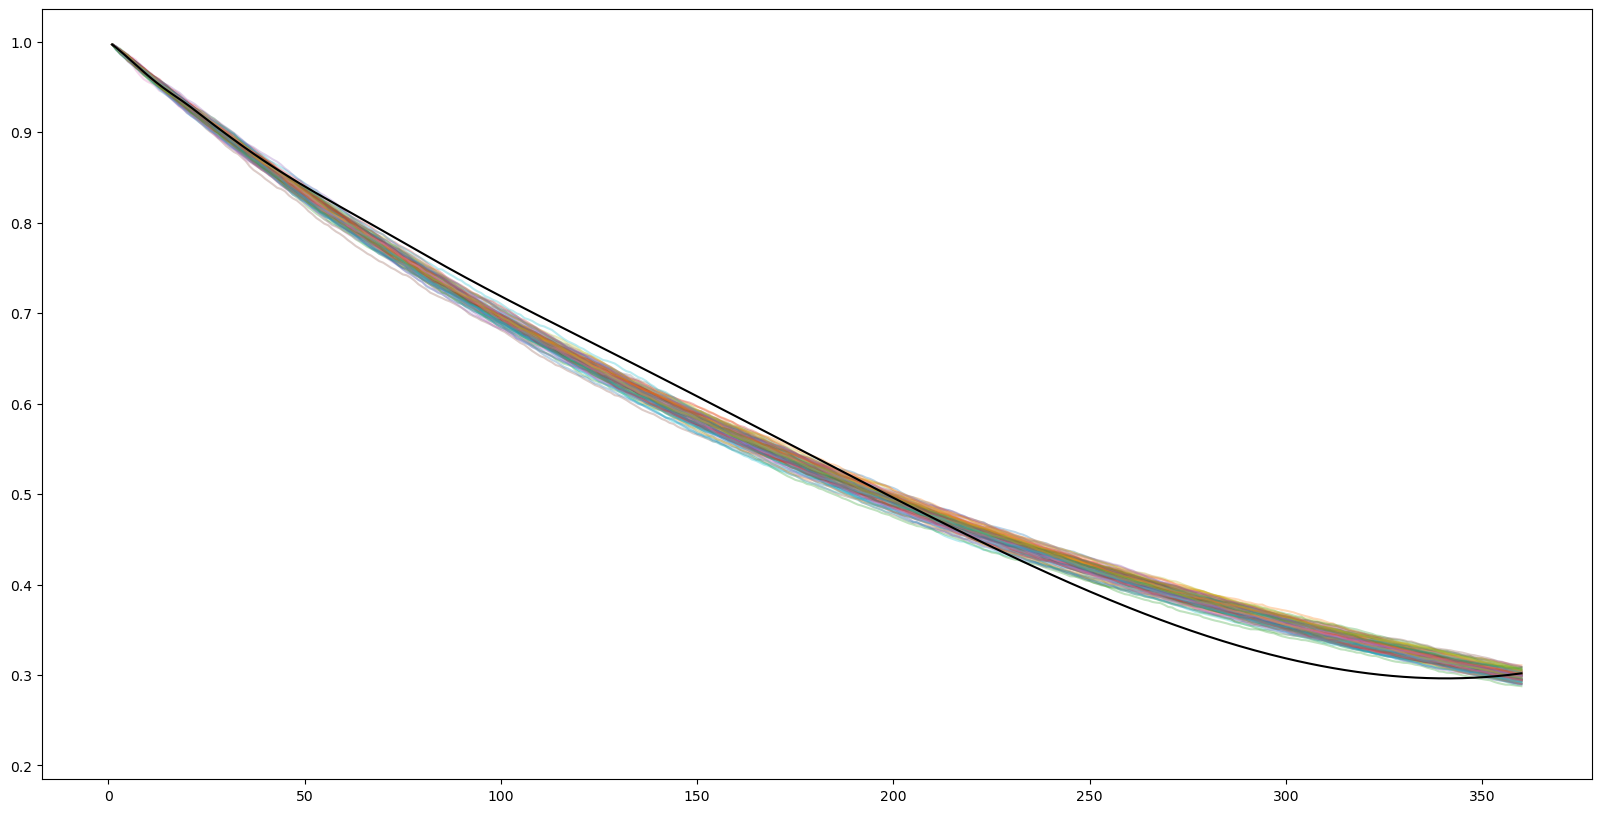

In [10]:
row = df.iloc[6]
model = CIRModel()
fit_to_row(model, row)
plot_results_row(model, row)

## Hull-White model

success: True , message: Optimization terminated successfully.
model parameters:
 0.16340285422674716 [0.00738669 0.00603764 0.00731921 0.01151345 0.01065863 0.01134279
 0.00788938 0.00823059 0.01079883 0.008866   0.00885991 0.00682318
 0.00733775 0.01078139 0.00681756 0.01471752 0.00879278 0.01145729
 0.01405055 0.00970443 0.01025974 0.00901564 0.01394143 0.01386073
 0.01046054 0.01144614 0.00998461 0.01065343 0.01504856 0.01420848
 0.01109743 0.01369664 0.01596797 0.01096188 0.00928557 0.01236813
 0.0147517  0.01172404 0.0130702  0.01141576 0.00974062 0.00851879
 0.01146203 0.01181248 0.00983176 0.00683045 0.00951018 0.01226472
 0.00929611 0.0122618  0.01287314 0.0122688  0.01420921 0.01212543
 0.00994327 0.01300732 0.01560978 0.01044725 0.01222654 0.01620734
 0.01123155 0.01053096 0.0113414  0.01361192 0.01162224 0.0127436
 0.01175589 0.01187461 0.01174297 0.0158151  0.01296652 0.00950315
 0.01189236 0.0101758  0.01117676 0.01042862 0.00960279 0.01313122
 0.01122895 0.01072515 0.008

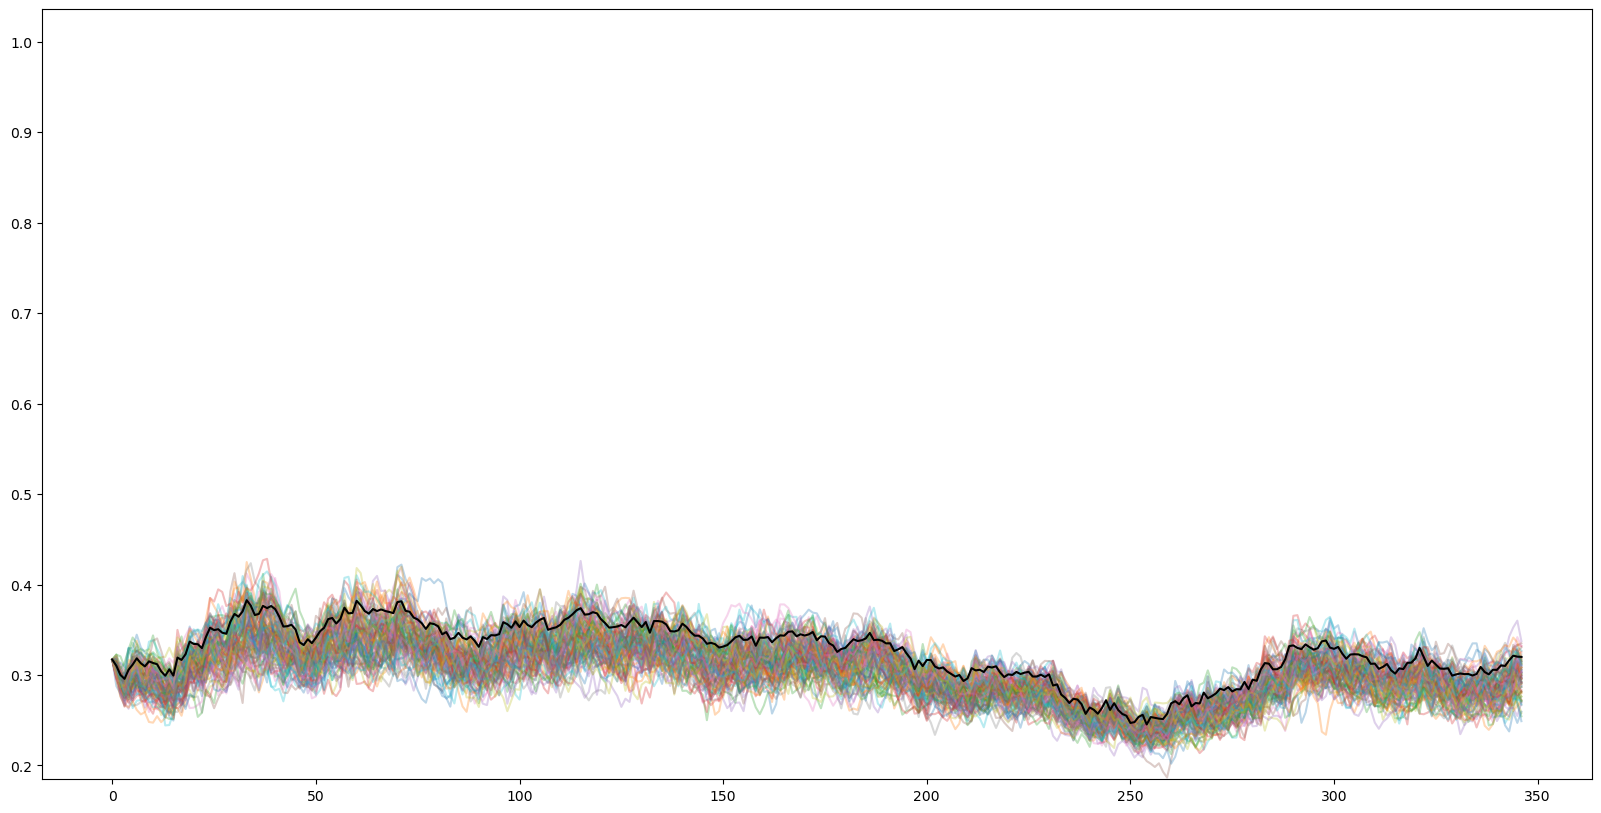

In [11]:
column = df['300']
model = HWModel()
fit_to_column(model, column)
plot_results_col(model, column)

success: True , message: Optimization terminated successfully.
model parameters:
 0.08958273179787236 [0.0200109  0.01985302 0.0197067  0.0195735  0.01945095 0.0193408
 0.01924129 0.01915252 0.01907294 0.01900151 0.01893794 0.01888055
 0.01882945 0.01877634 0.0187181  0.01865113 0.01857228 0.01847607
 0.01836262 0.01824857 0.01813704 0.01802833 0.01792605 0.01783413
 0.01775007 0.01766982 0.01758844 0.01750762 0.01742616 0.01734501
 0.01726247 0.0171809  0.01710225 0.01702458 0.01694745 0.01687475
 0.0168037  0.01673415 0.01666544 0.01659606 0.01652854 0.01646129
 0.01639398 0.01632867 0.01626274 0.01619938 0.01613439 0.01607126
 0.01600705 0.01594346 0.01587961 0.01581709 0.01575328 0.01568891
 0.01562522 0.01556064 0.01549516 0.01542937 0.01536208 0.01529387
 0.01522542 0.01515577 0.01508646 0.01501655 0.0149475  0.01487921
 0.01480834 0.01473933 0.0146691  0.01460121 0.01453245 0.01446297
 0.01439389 0.01432478 0.01425699 0.01418927 0.0141206  0.01405397
 0.01398653 0.01392093 0.013

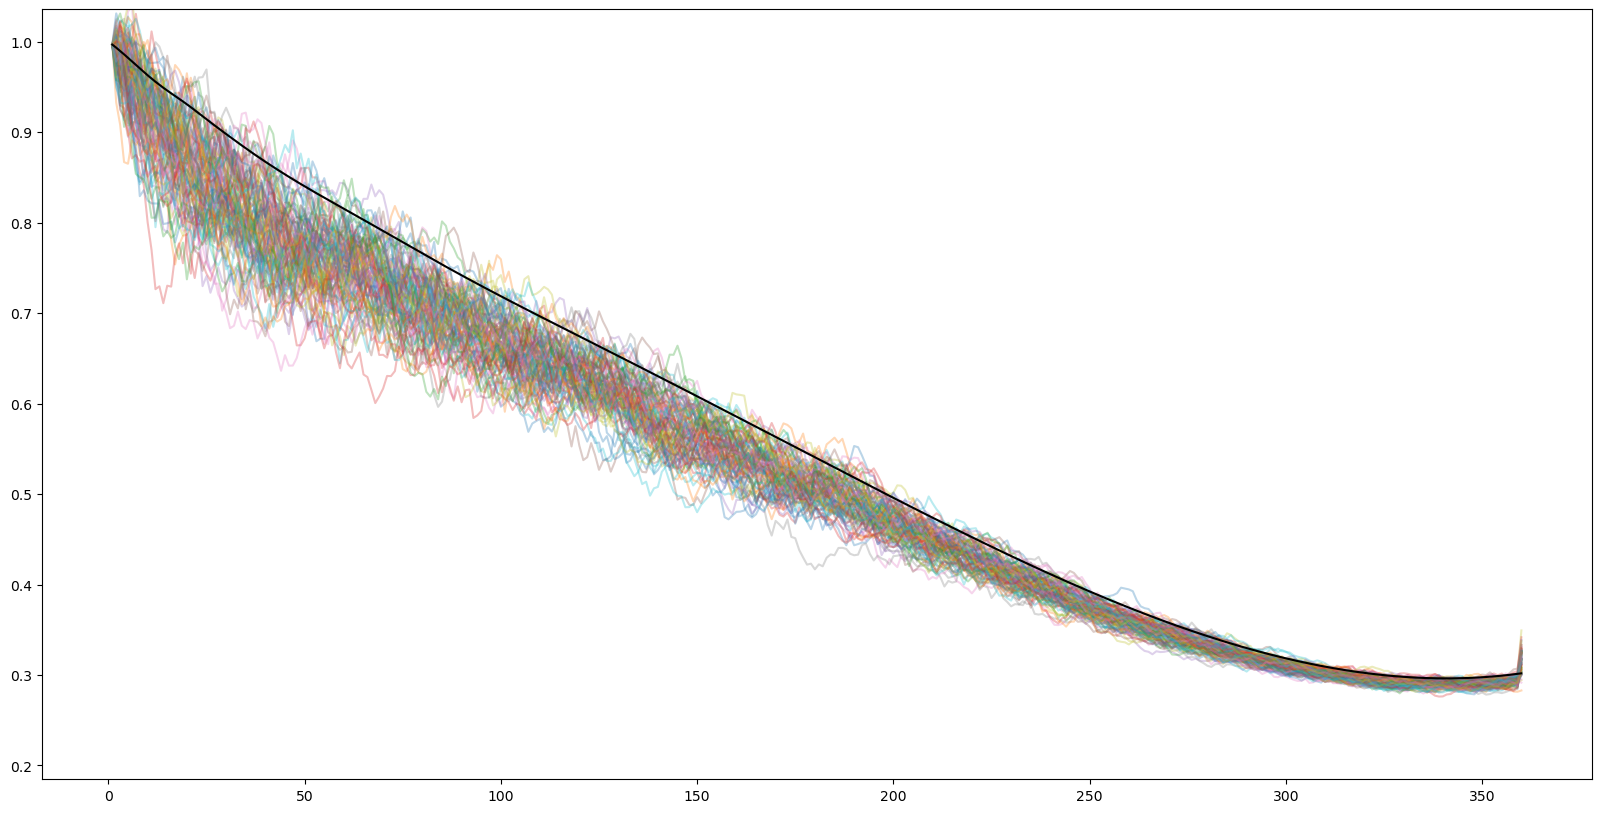

In [12]:
row = df.iloc[6]
model = HWModel()
fit_to_row(model, row)
plot_results_row(model, row)